In [2]:
# Import the os package
import os

# Import the openai package
import openai

import os
import openai
from scipy.spatial import distance
import plotly.express as px
from tqdm import tqdm
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [6]:
# all the concepts

concepts_syn_df = pd.read_csv("concept_synonyms_CVsubset.csv")

# Check for the missing rows where 'concept_name' is not in 'concept_synonym_name'
missing_rows = concepts_syn_df[~concepts_syn_df['concept_name'].isin(concepts_syn_df['concept_synonym_name'])]

# For each such case, add a new row where 'concept_name' and 'concept_synonym_name' are the same
for idx, row in missing_rows.iterrows():
    new_row = row.copy()
    new_row['concept_synonym_name'] = row['concept_name']
    concepts_syn_df = pd.concat([concepts_syn_df, pd.DataFrame([new_row])], ignore_index=True)

# Remove duplicates to ensure the new row is only added once
concepts_syn_df = concepts_syn_df.drop_duplicates()
concepts_syn_df = concepts_syn_df.reset_index(drop = True)

In [7]:
concepts_syn_df

,index,general_ancestor_concept_name,general_ancestor_concept_id,descendant_concept_id,concept_name,rc,dbc,drc,ddbc,max_levels_of_separation,concept_id,concept_synonym_name
0,0,Disorder of cardiovascular system,134057,443784,Vascular disorder,186458,13,1408753835,22,1,443784,Angiopathy
1,1,Disorder of cardiovascular system,134057,443784,Vascular disorder,186458,13,1408753835,22,1,443784,Disorder of blood vessel
2,2,Disorder of cardiovascular system,134057,443784,Vascular disorder,186458,13,1408753835,22,1,443784,Vascular disease
3,3,Disorder of cardiovascular system,134057,443784,Vascular disorder,186458,13,1408753835,22,1,443784,Disorder of blood vessel (disorder)
4,4,Disorder of cardiovascular system,134057,44784217,Cardiac arrhythmia,84417590,19,809155077,22,2,44784217,Arrhythmia
...,...,...,...,...,...,...,...,...,...,...,...,...
4629,6195,Disorder of cardiovascular system,134057,4226129,Hepatic artery stenosis,330,3,330,3,4,4226129,Hepatic artery stenosis
4630,6197,Disorder of cardiovascular system,134057,4270625,Primary idiopathic hypertrophic cardiomyopathy,328,3,328,3,6,4270625,Primary idiopathic hypertrophic cardiomyopathy
4631,6198,Disorder of cardiovascular system,134057,4023404,Congenital stenosis of pulmonary veins,319,3,319,3,6,4023404,Congenital stenosis of pulmonary veins
4632,6200,Disorder of cardiovascular system,134057,4253510,Erythrocyanosis,319,3,319,3,2,4253510,Erythrocyanosis


In [12]:
# all the concepts
concepts_df = concepts_syn_df['concept_synonym_name'].tolist()
unique_concepts = concepts_df #list(set(concepts_df))

print(f"unique concepts: {len(unique_concepts)}")

unique concepts: 4634


In [13]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")

In [14]:
from openai import OpenAI
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [15]:
concept_embeddings = []

for term in tqdm(unique_concepts):
    concept_embeddings.append(get_embedding(term))

100%|█████████████████████████████████████████| 4634/4634 [19:54<00:00,  3.88it/s]


In [16]:
df = pd.DataFrame(
    {'Term': unique_concepts,
     'Embedding': concept_embeddings
    })

df.head()

In [17]:
df

,Term,Embedding
0,Angiopathy,"[-0.023553520441055298, -0.016880663111805916,..."
1,Disorder of blood vessel,"[-0.0014156667748466134, 0.023290002718567848,..."
2,Vascular disease,"[-0.024115631356835365, 0.01850849762558937, 0..."
3,Disorder of blood vessel (disorder),"[0.004292594734579325, 0.03526625409722328, -0..."
4,Arrhythmia,"[-0.00971192866563797, -0.03246716782450676, -..."
...,...,...
4629,Hepatic artery stenosis,"[-0.037076082080602646, -0.03986550495028496, ..."
4630,Primary idiopathic hypertrophic cardiomyopathy,"[-0.038801636546850204, -0.018753279000520706,..."
4631,Congenital stenosis of pulmonary veins,"[-0.004176075104624033, -0.02769102156162262, ..."
4632,Erythrocyanosis,"[0.02523883804678917, -0.02087854966521263, -0..."


# Term Similarity

In [22]:
import ast
# Extract embeddings from the 'embedding' column
concepts_df['Embedding'] = concepts_df['Embedding'].apply(ast.literal_eval)
embeddings = np.array(concepts_df['Embedding'].tolist())

# Compute cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Create a new dataframe with the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=concepts_df['Term'], columns=concepts_df['Term'])

# Save the similarity matrix to a CSV file
similarity_df.to_csv("concept_similarity_matrix.csv")

In [26]:
similarity_df

,Angiopathy,Disorder of blood vessel,Vascular disease,Disorder of blood vessel (disorder),Arrhythmia,Disorder of heart rhythm,Cardiac dysrhythmia,Cardiac arrhythmia (disorder),Supraventricular arrhythmia (disorder),Heart failure (disorder),...,Dural arteriovenous fistula,Interventricular cardiac septal hypertrophy,Exertional hypotension,Popliteal entrapment syndrome,Hypertrophic cardiomegaly,Hepatic artery stenosis,Primary idiopathic hypertrophic cardiomyopathy,Congenital stenosis of pulmonary veins,Erythrocyanosis,Accelerated coronary artery disease in transplanted heart
Term,,,,,,,,,,,,,,,,,,,,,
Angiopathy,1.000000,0.465779,0.604926,0.452123,0.357728,0.258987,0.283116,0.265710,0.270883,0.340725,...,0.339531,0.254997,0.286296,0.315642,0.328787,0.471197,0.306734,0.290943,0.322548,0.441398
Disorder of blood vessel,0.465779,1.000000,0.617682,0.926637,0.427965,0.628649,0.402372,0.494268,0.492542,0.500052,...,0.359355,0.275799,0.233955,0.206238,0.261303,0.386477,0.274424,0.341880,0.289144,0.349562
Vascular disease,0.604926,0.617682,1.000000,0.581206,0.353206,0.342622,0.375961,0.343192,0.371074,0.414688,...,0.437029,0.396319,0.292279,0.262740,0.348852,0.479870,0.337701,0.355066,0.304343,0.437027
Disorder of blood vessel (disorder),0.452123,0.926637,0.581206,1.000000,0.431729,0.604211,0.408097,0.591757,0.560650,0.593856,...,0.333356,0.245431,0.223339,0.203074,0.235775,0.358560,0.241240,0.309060,0.292268,0.324889
Arrhythmia,0.357728,0.427965,0.353206,0.431729,1.000000,0.672207,0.731007,0.754216,0.582005,0.447381,...,0.220374,0.252455,0.271622,0.127936,0.235636,0.291366,0.286563,0.220285,0.357837,0.262906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hepatic artery stenosis,0.471197,0.386477,0.479870,0.358560,0.291366,0.241225,0.279959,0.245981,0.308037,0.338357,...,0.444439,0.412509,0.288371,0.339698,0.376107,1.000000,0.357590,0.519190,0.357993,0.463589
Primary idiopathic hypertrophic cardiomyopathy,0.306734,0.274424,0.337701,0.241240,0.286563,0.341062,0.389367,0.321003,0.356669,0.324295,...,0.209721,0.582663,0.311947,0.226140,0.642569,0.357590,1.000000,0.343519,0.299520,0.399836
Congenital stenosis of pulmonary veins,0.290943,0.341880,0.355066,0.309060,0.220285,0.299990,0.255851,0.217639,0.353594,0.259774,...,0.391746,0.466348,0.200220,0.332197,0.379469,0.519190,0.343519,1.000000,0.356272,0.337279


# test 1: Use 80% of data, find best threshold, test on 20%

In [27]:
# Prepare the ground truth binary matrix
term_list = concepts_syn_df['concept_synonym_name'].unique()
term_to_index = {term: i for i, term in enumerate(term_list)}
n_terms = len(term_list)

# Create true_matrix (1 if synonyms, 0 otherwise)
true_matrix = np.zeros((n_terms, n_terms))
for _, group in concepts_syn_df.groupby('concept_id'):
    indices = [term_to_index[term] for term in group['concept_synonym_name']]
    for i in indices:
        for j in indices:
            true_matrix[i, j] = 1

true_df = pd.DataFrame(true_matrix, index=concepts_syn_df['concept_synonym_name'], 
                       columns=concepts_syn_df['concept_synonym_name'])


In [29]:
# Flatten matrices for comparison

# only get upper triangles
# Create a mask to extract the upper triangle without the diagonal
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)

# Use the mask to filter the DataFrame
upper_triangle_sim_df = similarity_df.where(mask)
upper_triangle_ytrue = true_df.where(mask)

In [30]:
# y_true = upper_triangle_ytrue.flatten()
y_true_array = upper_triangle_ytrue.values
y_true_values = y_true_array.flatten()

similarity_matrix_array = upper_triangle_sim_df.values
similarity_values = similarity_matrix_array.flatten()

In [107]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Get the upper triangle indices
n = int(np.sqrt(len(y_true_values)))  # Since the matrix is flattened, we can get the size from its length
upper_triangle_indices = np.triu_indices(n, k=1)  # k=1 to exclude diagonal

# Only keep the values from the upper triangle (excluding the diagonal)
y_true_upper_triangle = y_true_array[upper_triangle_indices] # these are not yet flattened
similarity_values_upper_triangle = similarity_matrix_array[upper_triangle_indices]

# Split the data, holding out 20% for testing
all_indices = list(range(len(y_true_upper_triangle)))
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

y_true_train = y_true_upper_triangle[train_indices]
y_true_test = y_true_upper_triangle[test_indices]

similarity_values_train = similarity_values_upper_triangle[train_indices]
similarity_values_test = similarity_values_upper_triangle[test_indices]


In [252]:
# Initialize lists to store F1, precision, recall
f1_scores = []
precisions = []
recalls = []
best_f1 = 0
best_threshold = 0
thresholds = np.arange(0.7, 1, 0.01)

# Iterate through thresholds from 0.7 to 0.99
for threshold in tqdm(thresholds):
    # Make predictions based on threshold
    y_pred = (similarity_values_train >= threshold).astype(int)
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_train, y_pred, average='binary')
    
    # Append the results to the lists
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold:.2f}, F1 Score: {best_f1:.2f}")

 97%|███████████████████████████████████████████▌ | 30/31 [02:37<00:05,  5.26s/it]/Users/hc3292/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|█████████████████████████████████████████████| 31/31 [02:42<00:00,  5.23s/it]

Optimal Threshold: 0.82, F1 Score: 0.37


In [253]:
# now to evaluate on the held out 20%

y_pred_test = (similarity_values_test >= best_threshold).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='binary')

print(f"Test precision: {precision:.2f}, Test recall: {recall:.2f}, Test F1 Score: {f1:.2f}")

Test precision: 0.34, Test recall: 0.41, Test F1 Score: 0.37


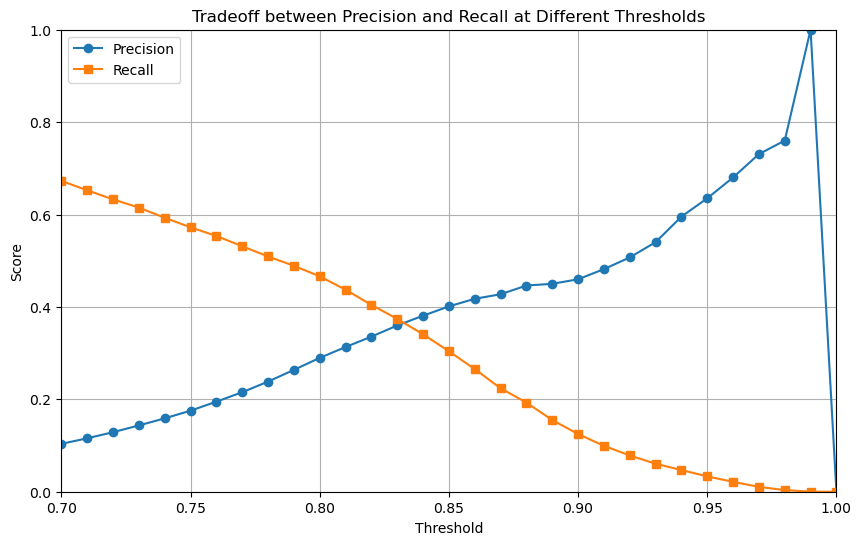

In [254]:
# plots for the test results
import matplotlib.pyplot as plt

thresholds = np.arange(0.7, 1, 0.01)

# Plot precision vs recall for thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", marker='o')
plt.plot(thresholds, recalls, label="Recall", marker='s')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Tradeoff between Precision and Recall at Different Thresholds")
plt.legend()
plt.ylim((0,1))
plt.xlim((0.7, 1))
plt.grid(True)
plt.show()


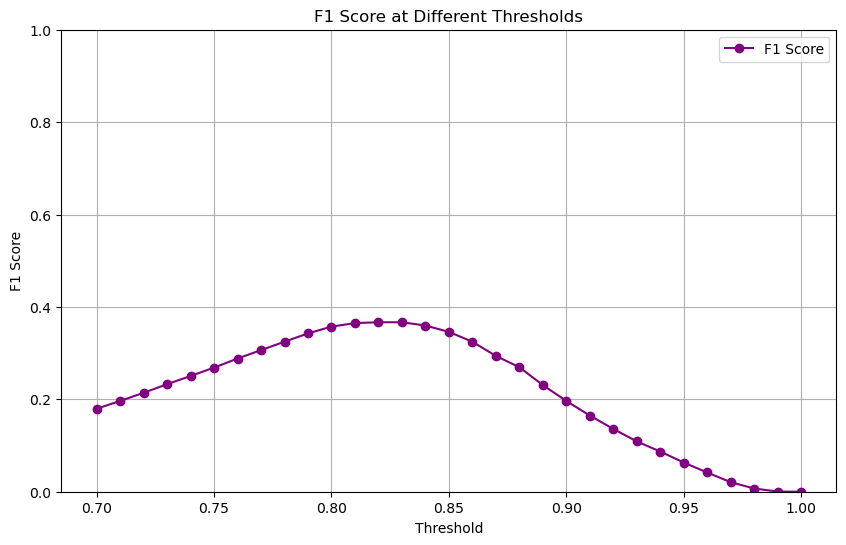

In [255]:
# Plot F1 score for thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label="F1 Score", marker='o', color='purple')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score at Different Thresholds")
plt.legend()
plt.ylim((0,1))
plt.grid(True)
plt.show()

# take best threshold and prompt ChatGPT

In [296]:
# chatGPT prompt for similarity
def generate_term_similarity(term1, term2):
    
    # Construct the prompt for the current chunk
    prompt = f"""are "{term1}" and "{term2}" medical synonyms?"""

    # Call the API for each chunk
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
                {
                    "role": "system", 
                    "content": """You are a helpful assistant. You will answer 1 if two terms are medical synonyms, and 
                    0 if not."""
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            max_tokens=1,  # Adjust if necessary for your use case
            temperature=0  # Low temperature for clearer, more focused responses
    )

    # Extract the full response text from the chat model response
    response = response.choices[0].message.content
    
    return response  # Return the combined response or process it further

In [204]:
re_predict_idx = np.where(similarity_values_test >= best_threshold)

In [246]:
terms = similarity_df.columns

# Get the upper triangle indices (excluding the diagonal)
upper_triangle_indices = np.triu_indices(n, k=1)

# Now, use these indices to map back to the original row and column names
rows, cols = upper_triangle_indices

# Map the indices to the corresponding terms (column names)
terms_rows = np.array(terms)[rows]
terms_cols = np.array(terms)[cols]

# Optionally, pair the terms and view them
term_pairs = list(zip(terms_rows, terms_cols))

In [248]:
# Extract the corresponding term pairs for the test set
termnames_train = [term_pairs[i] for i in train_indices]
termnames_test = [term_pairs[i] for i in test_indices]

[('Angiopathy', 'Disorder of blood vessel'),
 ('Angiopathy', 'Vascular disease'),
 ('Angiopathy', 'Disorder of blood vessel (disorder)'),
 ('Angiopathy', 'Arrhythmia'),
 ('Angiopathy', 'Disorder of heart rhythm'),
 ('Angiopathy', 'Cardiac dysrhythmia'),
 ('Angiopathy', 'Cardiac arrhythmia (disorder)'),
 ('Angiopathy', 'Supraventricular arrhythmia (disorder)'),
 ('Angiopathy', 'Heart failure (disorder)'),
 ('Angiopathy', 'HF - Heart failure'),
 ('Angiopathy', 'Myocardial failure'),
 ('Angiopathy', 'Cardiac failure'),
 ('Angiopathy', 'Cardiac insufficiency'),
 ('Angiopathy', 'Weak heart'),
 ('Angiopathy', 'Atrial arrhythmia (disorder)'),
 ('Angiopathy', 'Cardiac fibrillation'),
 ('Angiopathy', 'Fibrillation (disorder)'),
 ('Angiopathy', 'Atrial fibrillation (disorder)'),
 ('Angiopathy', 'AF - Atrial fibrillation'),
 ('Angiopathy', 'Benign hypertension (disorder)'),
 ('Angiopathy', 'Benign essential hypertension (disorder)'),
 ('Angiopathy', 'Acute disorder of cardiovascular system'),
 ('

In [258]:
termnames_test_df = pd.DataFrame(termnames_test, columns=["Term 1", "Term 2"])


In [272]:
re_pred_term_pairs = termnames_test_df.iloc[re_predict_idx].reset_index(drop=True)
re_pred_term_pairs

,Term 1,Term 2
0,Non-rheumatic mitral valve stenosis,Non-rheumatic mitral valve stenosis with regur...
1,Total anomalous pulmonary venous return (disor...,Partial anomalous pulmonary venous return
2,Acute rheumatic pericarditis (disorder),Acute rheumatic pericarditis
3,Congenital mitral valve abnormality,Congenital anomaly of mitral valve (disorder)
4,Vertebral artery syndrome (disorder),Vertebral artery stenosis (disorder)
...,...,...
1635,Subacute endocarditis,Subacute bacterial endocarditis
1636,PPVL - Prosthetic paravalvular leak,Prosthetic cardiac paravalvular leak
1637,Proteinuric hypertension of pregnancy,Moderate proteinuric hypertension of pregnancy
1638,Phlebitis of superficial veins of lower extrem...,Thrombophlebitis of deep veins of upper extrem...


In [273]:
final_result = []
# Iterate over each row in predicted_term_pairs
for _, row in tqdm(re_pred_term_pairs.iterrows(), total=re_pred_term_pairs.shape[0]):
    term1, term2 = row['Term 1'], row['Term 2']  # Extract terms from each row
    final_result.append(generate_term_similarity(term1, term2))  # Call the function for each term pair


100%|█████████████████████████████████████████| 1640/1640 [11:02<00:00,  2.47it/s]


In [274]:
final_result = [int(item) for item in final_result]
y_pred_test[re_predict_idx] = final_result

In [275]:
re_pred_term_pairs['result'] = final_result
re_pred_term_pairs['true'] = y_true_test[re_predict_idx]
re_pred_term_pairs['cosine'] = similarity_values_test[re_predict_idx]

y_pred_test_thres = (similarity_values_test >= best_threshold).astype(int)
re_pred_term_pairs['threshold_res'] = y_pred_test_thres[re_predict_idx]

In [278]:
re_pred_term_pairs

,Term 1,Term 2,result,true,cosine,threshold_res
0,Non-rheumatic mitral valve stenosis,Non-rheumatic mitral valve stenosis with regur...,0,0.0,0.900402,1
1,Total anomalous pulmonary venous return (disor...,Partial anomalous pulmonary venous return,0,0.0,0.856902,1
2,Acute rheumatic pericarditis (disorder),Acute rheumatic pericarditis,1,1.0,0.825466,1
3,Congenital mitral valve abnormality,Congenital anomaly of mitral valve (disorder),1,1.0,0.820876,1
4,Vertebral artery syndrome (disorder),Vertebral artery stenosis (disorder),0,0.0,0.876716,1
...,...,...,...,...,...,...
1635,Subacute endocarditis,Subacute bacterial endocarditis,1,0.0,0.955815,1
1636,PPVL - Prosthetic paravalvular leak,Prosthetic cardiac paravalvular leak,1,1.0,0.878617,1
1637,Proteinuric hypertension of pregnancy,Moderate proteinuric hypertension of pregnancy,0,0.0,0.898773,1
1638,Phlebitis of superficial veins of lower extrem...,Thrombophlebitis of deep veins of upper extrem...,0,0.0,0.834895,1


In [279]:
# find changes
filtered_df = re_pred_term_pairs[re_pred_term_pairs['threshold_res'] != re_pred_term_pairs['result']]

# Display the filtered DataFrame
filtered_df

,Term 1,Term 2,result,true,cosine,threshold_res
0,Non-rheumatic mitral valve stenosis,Non-rheumatic mitral valve stenosis with regur...,0,0.0,0.900402,1
1,Total anomalous pulmonary venous return (disor...,Partial anomalous pulmonary venous return,0,0.0,0.856902,1
4,Vertebral artery syndrome (disorder),Vertebral artery stenosis (disorder),0,0.0,0.876716,1
6,Dissection of artery (disorder),Dissection of aorta (disorder),0,0.0,0.879695,1
7,Rheumatic disease of heart valve,Rheumatic disease of aortic valve,0,0.0,0.841343,1
...,...,...,...,...,...,...
1629,Chronic gastric ulcer with hemorrhage (disorder),Acute gastric ulcer with hemorrhage (disorder),0,0.0,0.939533,1
1632,Oesophageal varices,Oesophageal varices without bleeding,0,0.0,0.823407,1
1637,Proteinuric hypertension of pregnancy,Moderate proteinuric hypertension of pregnancy,0,0.0,0.898773,1
1638,Phlebitis of superficial veins of lower extrem...,Thrombophlebitis of deep veins of upper extrem...,0,0.0,0.834895,1


In [280]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='binary')

print(f"Test precision: {precision:.2f}, Test recall: {recall:.2f}, Test F1 Score: {f1:.2f}")

Test precision: 0.78, Test recall: 0.41, Test F1 Score: 0.53


In [ ]:
# 1640 > threshold
# changed 932 results from 1 to 0 
# increased test precision
# Test precision: 0.78, Test recall: 0.41, Test F1 Score: 0.53